# MLP Neural Network Classifier for Imbalanced Data

This notebook trains a Multi-Layer Perceptron (MLP) neural network classifier on the highly imbalanced Porto Seguro dataset (96.36% class 0, 3.64% class 1).

## 1. Import Libraries
- sklearn.neural_network.MLPClassifier
- StandardScaler (critical for neural networks)
- All necessary evaluation metrics

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Cleaned Data

Load the cleaned training data from the pickle file.

In [8]:
# Load cleaned training data
print("Loading cleaned data...")
train_df = pd.read_pickle('data/train_cleaned.pkl')

print(f"Shape: {train_df.shape}")
print(f"\nTarget distribution:")
print(train_df['target'].value_counts())
print(f"\nTarget rate: {train_df['target'].mean():.4f}")
print(f"Imbalance ratio: {(train_df['target']==0).sum() / (train_df['target']==1).sum():.2f}:1")

Loading cleaned data...
Shape: (595212, 35)

Target distribution:
target
0    573518
1     21694
Name: count, dtype: int64

Target rate: 0.0364
Imbalance ratio: 26.44:1


## 3. Prepare Features and Target
- Shows dataset statistics and imbalance ratio
- Separates features and target


In [10]:
# Separate features and target
X = train_df.drop(columns=['target'])
y = train_df['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")

Features shape: (595212, 34)
Target shape: (595212,)
Number of features: 34


## 4. Train-Validation Split
Creates train/validation split


In [11]:
# Split with stratification to maintain class balance
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_valid.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

Training set: (476169, 34)
Validation set: (119043, 34)

Training target distribution:
target
0    458814
1     17355
Name: count, dtype: int64


## 5. Feature Scaling

⚠️ **CRITICAL for Neural Networks**: MLPs are sensitive to feature scales. We must standardize features to have mean=0 and std=1.


In [12]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both train and validation
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

print("Feature scaling completed!")
print(f"\nScaled training data - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"Scaled validation data - Mean: {X_valid_scaled.mean():.6f}, Std: {X_valid_scaled.std():.6f}")

Feature scaling completed!

Scaled training data - Mean: 0.000000, Std: 1.000000
Scaled validation data - Mean: 0.000938, Std: 1.001743


## 6. Calculate Class Weights

For the imbalanced dataset, we'll compute class weights to give more importance to the minority class (claims).

In [13]:
# Calculate class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(f"Class weights: {class_weight_dict}")
print(f"Class 0 (no claim) weight: {class_weight_dict[0]:.4f}")
print(f"Class 1 (claim) weight: {class_weight_dict[1]:.4f}")
print(f"\nThe minority class (claims) will be weighted ~{class_weight_dict[1]/class_weight_dict[0]:.1f}x higher")

Class weights: {0: 0.5189128928062352, 1: 13.718496110630943}
Class 0 (no claim) weight: 0.5189
Class 1 (claim) weight: 13.7185

The minority class (claims) will be weighted ~26.4x higher


## 7. Train MLP Neural Network

Training a Multi-Layer Perceptron with:
- Two hidden layers (100, 50 neurons)
- ReLU activation
- Adam optimizer
- Early stopping to prevent overfitting
- Class weights for imbalanced data

In [14]:
print("Training MLP Neural Network...\n")

# Initialize MLP with appropriate settings for imbalanced data
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),    # Two hidden layers
    activation='relu',               # ReLU activation function
    solver='adam',                   # Adam optimizer
    alpha=0.0001,                    # L2 regularization
    batch_size='auto',               # Automatic batch size
    learning_rate='adaptive',        # Adaptive learning rate
    learning_rate_init=0.001,        # Initial learning rate
    max_iter=200,                    # Maximum iterations
    shuffle=True,                    # Shuffle training data
    random_state=42,
    early_stopping=True,             # Enable early stopping
    validation_fraction=0.1,         # Use 10% for early stopping validation
    n_iter_no_change=10,             # Stop if no improvement for 10 iterations
    verbose=True                     # Show progress
)

# Train the model
mlp.fit(X_train_scaled, y_train)

print(f"\nTraining completed!")
print(f"Number of iterations: {mlp.n_iter_}")
print(f"Number of layers: {mlp.n_layers_}")
print(f"Output activation: {mlp.out_activation_}")

Training MLP Neural Network...

Iteration 1, loss = 0.15995016
Validation score: 0.963542
Iteration 2, loss = 0.15362909
Validation score: 0.963542
Iteration 3, loss = 0.15299333
Validation score: 0.963542
Iteration 4, loss = 0.15270099
Validation score: 0.963542
Iteration 5, loss = 0.15248167
Validation score: 0.963542
Iteration 6, loss = 0.15216657
Validation score: 0.963542
Iteration 7, loss = 0.15179890
Validation score: 0.963542
Iteration 8, loss = 0.15159930
Validation score: 0.963542
Iteration 9, loss = 0.15130704
Validation score: 0.963542
Iteration 10, loss = 0.15099873
Validation score: 0.963542
Iteration 11, loss = 0.15072384
Validation score: 0.963542
Iteration 12, loss = 0.15038611
Validation score: 0.963542
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Training completed!
Number of iterations: 12
Number of layers: 4
Output activation: logistic


## 8. Training Loss Curve

Visualize how the loss decreased during training.

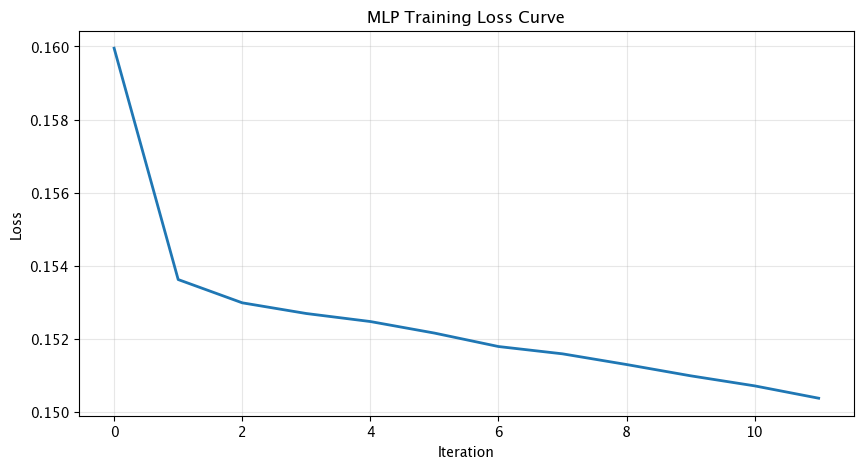

Final training loss: 0.150386


In [15]:
# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(mlp.loss_curve_, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('MLP Training Loss Curve')
plt.grid(alpha=0.3)
plt.show()

print(f"Final training loss: {mlp.loss_:.6f}")

## 9. Evaluate Model Performance

In [16]:
# Predict probabilities and classes
y_pred_proba = mlp.predict_proba(X_valid_scaled)[:, 1]
y_pred = mlp.predict(X_valid_scaled)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f"Validation ROC AUC: {roc_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_valid, y_pred, target_names=['No Claim', 'Claim']))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Validation ROC AUC: 0.6179

Classification Report:
              precision    recall  f1-score   support

    No Claim       0.96      1.00      0.98    114704
       Claim       0.00      0.00      0.00      4339

    accuracy                           0.96    119043
   macro avg       0.48      0.50      0.49    119043
weighted avg       0.93      0.96      0.95    119043


Confusion Matrix:
[[114704      0]
 [  4339      0]]


/Users/simonvoegely/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/simonvoegely/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/simonvoegely/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## 10. ROC Curve Visualization

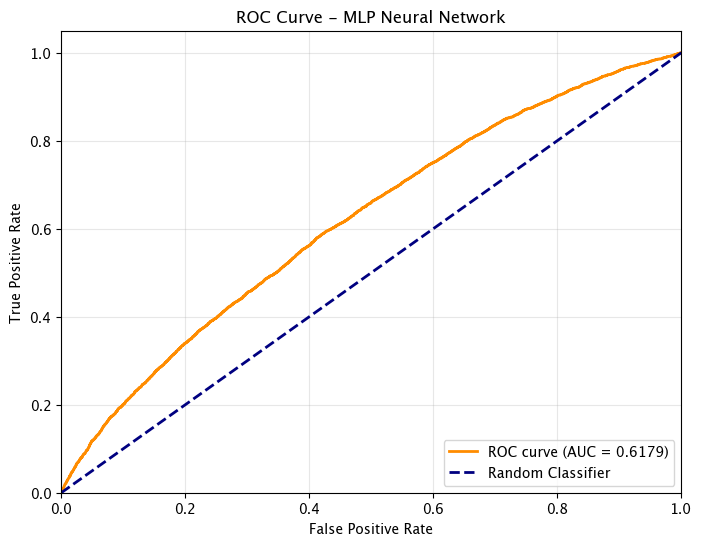

In [17]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP Neural Network')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 11. Confusion Matrix Heatmap

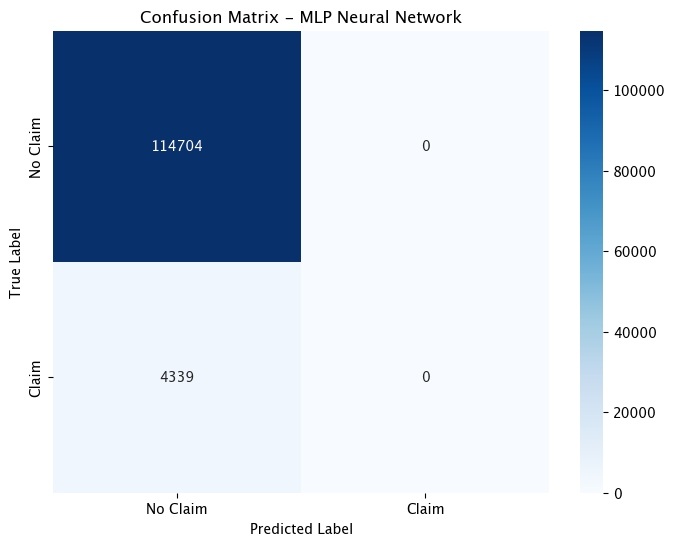


Detailed Metrics:
True Negatives: 114,704
False Positives: 0
False Negatives: 4,339
True Positives: 0

Sensitivity (Recall): 0.0000
Specificity: 1.0000
Precision: nan
F1-Score: 0.0000


/var/folders/l4/3hxx46b95s569c0bb0mbdfc00000gn/T/ipykernel_3061/112545884.py:20: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Precision: {tp/(tp+fp):.4f}")


In [18]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Claim', 'Claim'],
            yticklabels=['No Claim', 'Claim'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - MLP Neural Network')
plt.show()

# Calculate detailed metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Metrics:")
print(f"True Negatives: {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives: {tp:,}")
print(f"\nSensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1-Score: {2*tp/(2*tp+fp+fn):.4f}")

## 12. Prediction Distribution Analysis

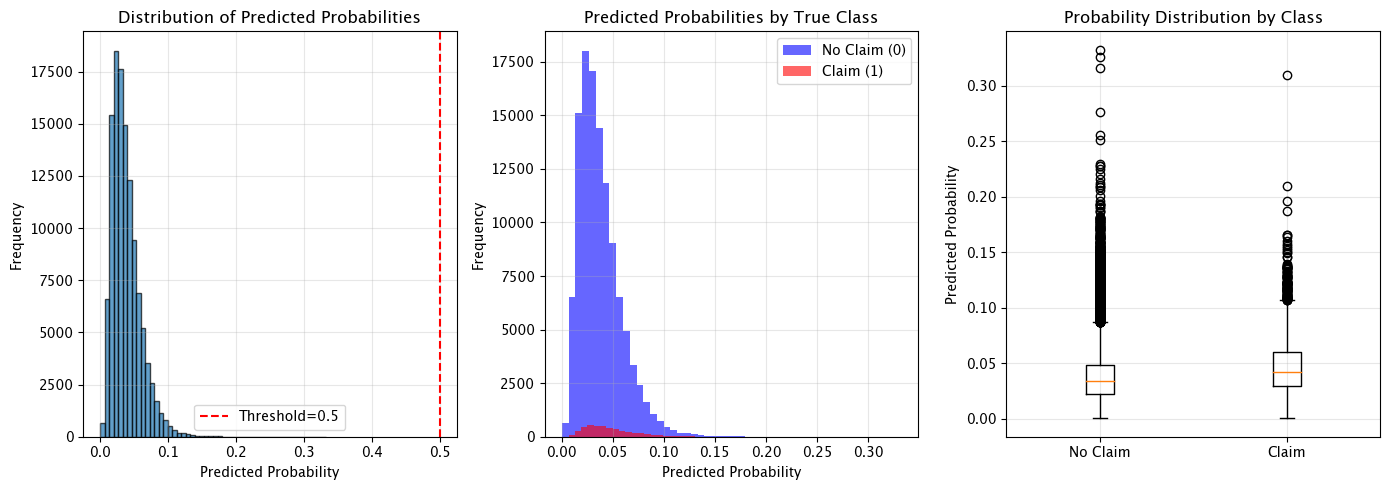


Predicted probability statistics:
Overall - Mean: 0.0381, Median: 0.0337, Std: 0.0212
Class 0 - Mean: 0.0378
Class 1 - Mean: 0.0471


In [19]:
# Analyze prediction probability distribution
plt.figure(figsize=(14, 5))

# Subplot 1: Overall distribution
plt.subplot(1, 3, 1)
plt.hist(y_pred_proba, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold=0.5')
plt.legend()
plt.grid(alpha=0.3)

# Subplot 2: By actual class
plt.subplot(1, 3, 2)
plt.hist(y_pred_proba[y_valid == 0], bins=50, alpha=0.6, label='No Claim (0)', color='blue')
plt.hist(y_pred_proba[y_valid == 1], bins=50, alpha=0.6, label='Claim (1)', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probabilities by True Class')
plt.legend()
plt.grid(alpha=0.3)

# Subplot 3: Box plot comparison
plt.subplot(1, 3, 3)
data_to_plot = [y_pred_proba[y_valid == 0], y_pred_proba[y_valid == 1]]
plt.boxplot(data_to_plot, labels=['No Claim', 'Claim'])
plt.ylabel('Predicted Probability')
plt.title('Probability Distribution by Class')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPredicted probability statistics:")
print(f"Overall - Mean: {y_pred_proba.mean():.4f}, Median: {np.median(y_pred_proba):.4f}, Std: {y_pred_proba.std():.4f}")
print(f"Class 0 - Mean: {y_pred_proba[y_valid==0].mean():.4f}")
print(f"Class 1 - Mean: {y_pred_proba[y_valid==1].mean():.4f}")

## 13. Model Architecture Visualization

In [20]:
# Display network architecture
print("MLP Neural Network Architecture:")
print("="*50)
print(f"Input Layer: {X_train.shape[1]} features")
for i, layer_size in enumerate(mlp.hidden_layer_sizes, 1):
    print(f"Hidden Layer {i}: {layer_size} neurons (ReLU activation)")
print(f"Output Layer: 2 classes (Softmax activation)")
print("="*50)

# Count total parameters
total_params = sum([coef.size for coef in mlp.coefs_])
print(f"\nTotal trainable parameters: {total_params:,}")

# Layer sizes
print("\nLayer-wise parameter count:")
for i, coef in enumerate(mlp.coefs_):
    print(f"Layer {i} → Layer {i+1}: {coef.shape[0]} × {coef.shape[1]} = {coef.size:,} weights")

MLP Neural Network Architecture:
Input Layer: 34 features
Hidden Layer 1: 100 neurons (ReLU activation)
Hidden Layer 2: 50 neurons (ReLU activation)
Output Layer: 2 classes (Softmax activation)

Total trainable parameters: 8,450

Layer-wise parameter count:
Layer 0 → Layer 1: 34 × 100 = 3,400 weights
Layer 1 → Layer 2: 100 × 50 = 5,000 weights
Layer 2 → Layer 3: 50 × 1 = 50 weights


## 14. Compare with Baseline

In [21]:
# Calculate baseline metrics
baseline_rate = y_train.mean()
baseline_pred = np.full_like(y_valid, baseline_rate)
baseline_auc = roc_auc_score(y_valid, baseline_pred)

print("Model Performance Comparison:")
print("="*50)
print(f"Baseline (always predict {baseline_rate:.4f}): {baseline_auc:.4f} AUC")
print(f"MLP Neural Network: {roc_auc:.4f} AUC")
print(f"\nImprovement over baseline: {(roc_auc - baseline_auc):.4f} (+{((roc_auc/baseline_auc - 1)*100):.2f}%)")
print("="*50)

Model Performance Comparison:
Baseline (always predict 0.0364): 0.5000 AUC
MLP Neural Network: 0.6179 AUC

Improvement over baseline: 0.1179 (+23.58%)


## Summary

This notebook demonstrates:
- Loading and preparing the imbalanced Porto Seguro dataset
- **Feature scaling** (critical for neural networks)
- Training an MLP with appropriate architecture for tabular data
- Using early stopping to prevent overfitting
- Evaluating performance using ROC AUC (best metric for imbalanced data)
- Visualizing training progress and predictions

### MLP Characteristics:

**✅ Strengths:**
- Can learn complex non-linear patterns
- Flexible architecture (can add more layers/neurons)
- Works well with large datasets
- Early stopping prevents overfitting

**⚠️ Considerations:**
- Requires feature scaling (done in this notebook)
- Longer training time than tree-based models
- Less interpretable than Random Forest
- Sensitive to hyperparameters
- May not outperform gradient boosting on tabular data

### Next Steps:
1. **Hyperparameter tuning**: Adjust hidden layers, learning rate, regularization
2. **Try different architectures**: More/fewer layers, different activation functions
3. **Class weights**: Experiment with manual class weight adjustments
4. **Feature engineering**: Create interaction features before scaling
5. **Ensemble**: Combine MLP with Random Forest and XGBoost
6. **Compare**: Check if MLP outperforms simpler models on this dataset

**Expected Performance:** MLPs typically achieve 0.62-0.66 AUC on Porto Seguro, similar to well-tuned Random Forest but often slightly below XGBoost/LightGBM for tabular data.